# Churn dataset EDA

In [68]:
import pandas as pd 
import numpy as np
from math import sqrt

import seaborn as sns
sns.set(rc={'figure.figsize':(11,5)})
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder

from scipy import stats
import xgboost as xgb
import re
import warnings # supress warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [45]:
def barplotsColumns(autos,nLower = 2,nUpper = 100):
    autos = autos[[col for col in autos if autos.nunique()[col] > nLower and autos.nunique()[col] < nUpper]] 
    _, nCol = autos.shape
    nGraphRow = (nCol + 5 - 1) / 5
    fig = plt.figure(num = None, figsize = (7 * 6, int(4 * nGraphRow)), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(nCol):
        plt.subplot(int(nGraphRow), 5, i + 1)
        columnDf = autos.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('Counts')
        plt.title('{}'.format(list(autos)[i]))
        
    fig.savefig('hi.jpg')

    plt.show()
    
def plot_dist(data,feature):    
  ac_len_churned = data[data['Churn']==1][feature]
  ac_len_not_churned =data[data['Churn']==0][feature]
  sns.distplot(ac_len_churned,label='Churned')
  sns.distplot(ac_len_not_churned,label='Not_churned')
  plt.title(f'Distribution of {feature}')
  plt.legend()
  plt.show()

def outliers(df, variable, scale):
    upper_limit = df[variable].mean() + scale * df[variable].std()
    lower_limit = df[variable].mean() - scale * df[variable].std()
    return upper_limit, lower_limit

In [46]:
path = './data/'
data = pd.read_excel(path + 'E Commerce Dataset.xlsx', sheet_name='E Comm')
data_dict = pd.read_excel(path + 'E Commerce Dataset.xlsx', sheet_name='Data Dict')

**1. Dataset columns explanation**

In [47]:
data_dict

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3
0,NaN,Data,Variable,Discerption
1,NaN,E Comm,CustomerID,Unique customer ID
2,NaN,E Comm,Churn,Churn Flag
3,NaN,E Comm,Tenure,Tenure of customer in organization
4,NaN,E Comm,PreferredLoginDevice,Preferred login device of customer
5,NaN,E Comm,CityTier,City tier
6,NaN,E Comm,WarehouseToHome,Distance in between warehouse to home of customer
7,NaN,E Comm,PreferredPaymentMode,Preferred payment method of customer
8,NaN,E Comm,Gender,Gender of customer
9,NaN,E Comm,HourSpendOnApp,Number of hours spend on mobile application or...


First five records

In [48]:
data.head()

,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


Columns with Missing values

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

CustemerID is useless - dropping

In [50]:
data.drop(['CustomerID'], axis=1, inplace = True)

In [51]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Churn,5630.0,0.168384,0.374240,0.0,0.00,0.00,0.0000,1.00
Tenure,5366.0,10.189899,8.557241,0.0,2.00,9.00,16.0000,61.00
CityTier,5630.0,1.654707,0.915389,1.0,1.00,1.00,3.0000,3.00
WarehouseToHome,5379.0,15.639896,8.531475,5.0,9.00,14.00,20.0000,127.00
HourSpendOnApp,5375.0,2.931535,0.721926,0.0,2.00,3.00,3.0000,5.00
NumberOfDeviceRegistered,5630.0,3.688988,1.023999,1.0,3.00,4.00,4.0000,6.00
SatisfactionScore,5630.0,3.066785,1.380194,1.0,2.00,3.00,4.0000,5.00
NumberOfAddress,5630.0,4.214032,2.583586,1.0,2.00,3.00,6.0000,22.00
Complain,5630.0,0.284902,0.451408,0.0,0.00,0.00,1.0000,1.00
OrderAmountHikeFromlastYear,5365.0,15.707922,3.675485,11.0,13.00,15.00,18.0000,26.00


Categorical

In [52]:
data.describe(include='object')

,PreferredLoginDevice,PreferredPaymentMode,Gender,PreferedOrderCat,MaritalStatus
count,5630,5630,5630,5630,5630
unique,3,7,2,6,3
top,Mobile Phone,Debit Card,Male,Laptop & Accessory,Married
freq,2765,2314,3384,2050,2986


**2. Data Visualization**

Total: 5630, not_churned: 4682, churned: 948


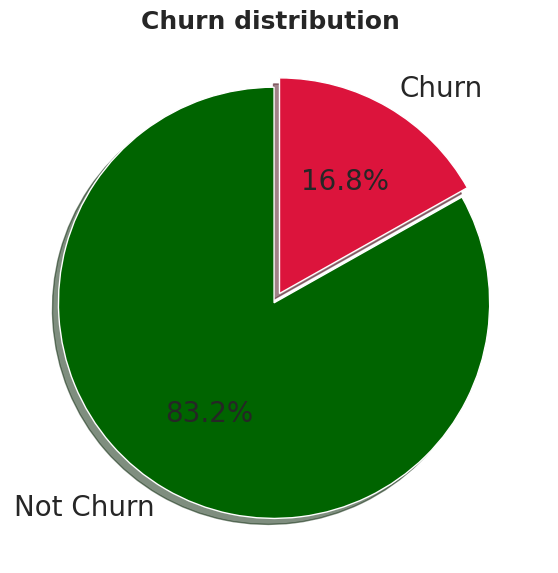

In [69]:
target = 'Churn'
labels = ['Not Churn', 'Churn']
sizes = data[target].value_counts(sort = True)
print(f'Total: {len(data)}, not_churned: {sizes[0]}, churned: {sizes[1]}')

colors = ["#006400","#dc143c"]
explode = (0.05,0) 
 
plt.figure(figsize=(7,7))
plt.suptitle("Churn distribution",y=0.9, size=18, weight='bold')
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90, textprops={"fontsize":20})

plt.show()

**3. Correlation**

In [ ]:
Columns with Missing values

In [55]:
corr = data.corr(numeric_only=True)[target]
corr

Churn                          1.000000
Tenure                        -0.349408
CityTier                       0.084703
WarehouseToHome                0.076630
HourSpendOnApp                 0.018675
NumberOfDeviceRegistered       0.107939
SatisfactionScore              0.105481
NumberOfAddress                0.043931
Complain                       0.250188
OrderAmountHikeFromlastYear   -0.010058
CouponUsed                    -0.008264
OrderCount                    -0.028697
DaySinceLastOrder             -0.160757
CashbackAmount                -0.154118
Name: Churn, dtype: float64

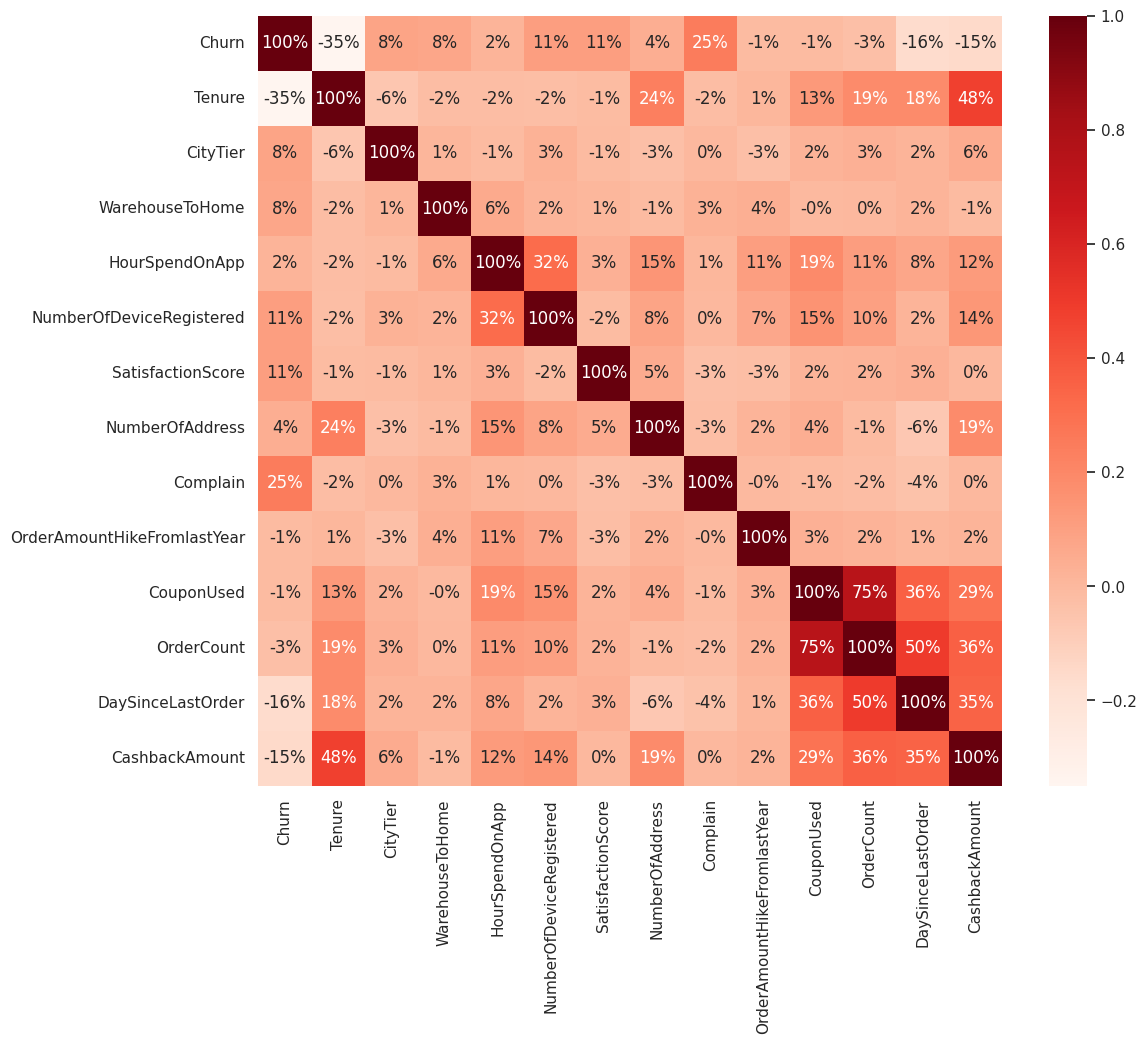

In [56]:
ax = plt.figure(figsize=(12,10))
sns.heatmap(data.corr(numeric_only=True),annot=True,cmap="Reds", fmt='.0%')
plt.show()

In [57]:
corr_cols = corr[(corr>0.05) | (corr<-0.05)].index.to_list()
corr_cols

['Churn',
 'Tenure',
 'CityTier',
 'WarehouseToHome',
 'NumberOfDeviceRegistered',
 'SatisfactionScore',
 'Complain',
 'DaySinceLastOrder',
 'CashbackAmount']

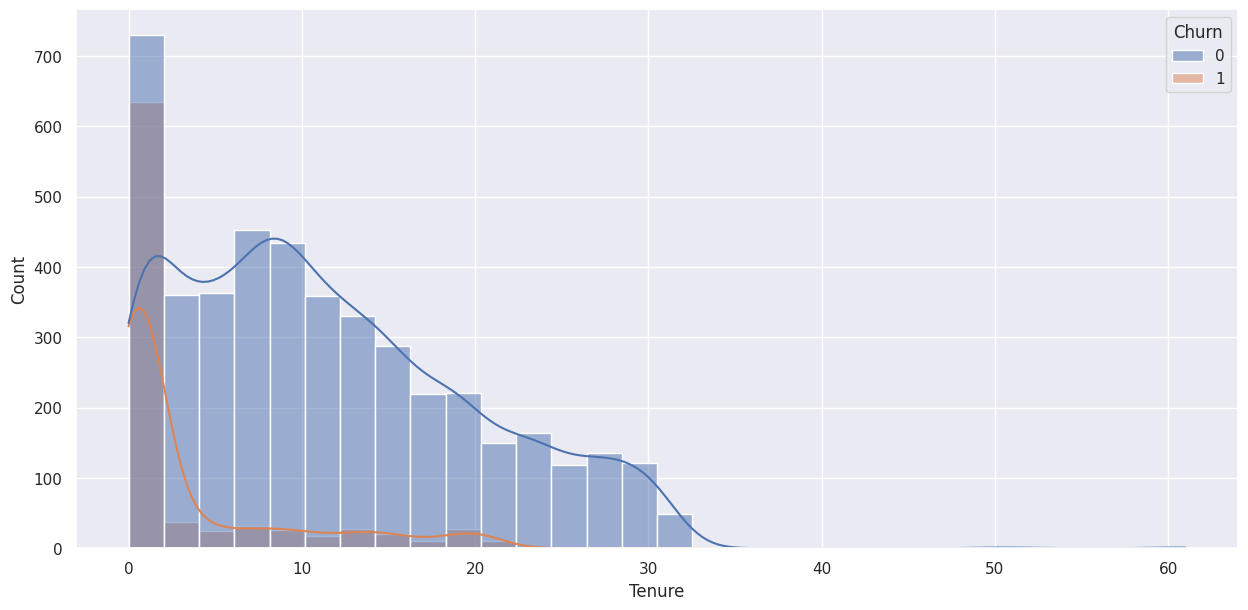

In [58]:
tenure = data[['Tenure']]
plt.figure(figsize=(15,7))
for i in tenure:
    sns.histplot(data=data,x=i,hue='Churn',kde=True,bins=30)
    plt.show()

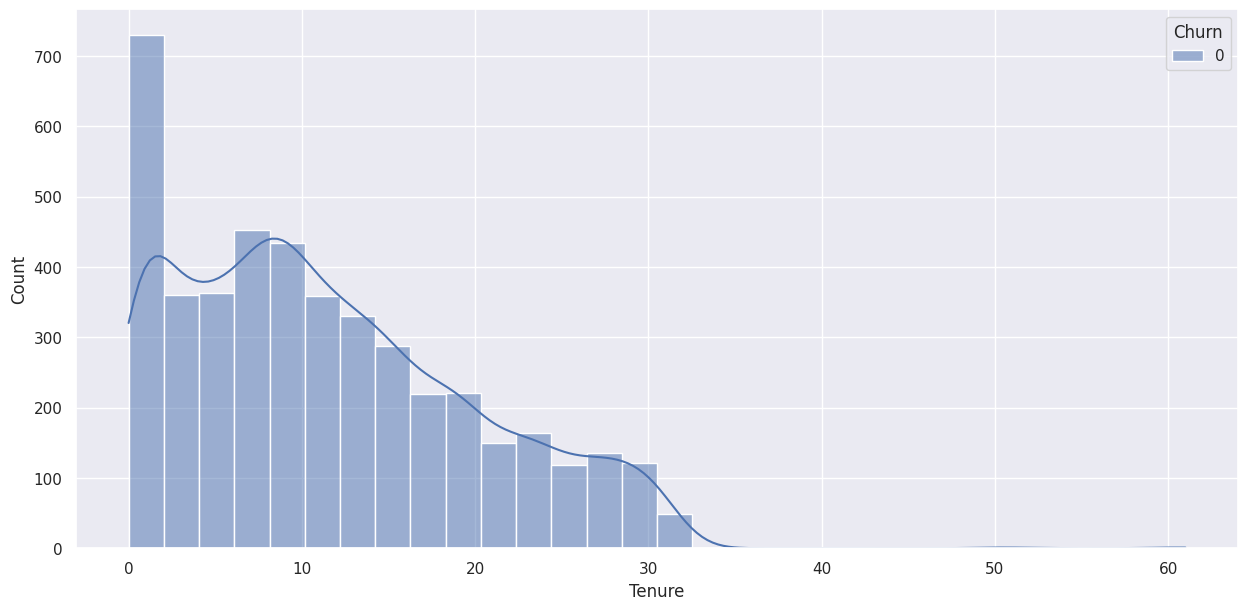

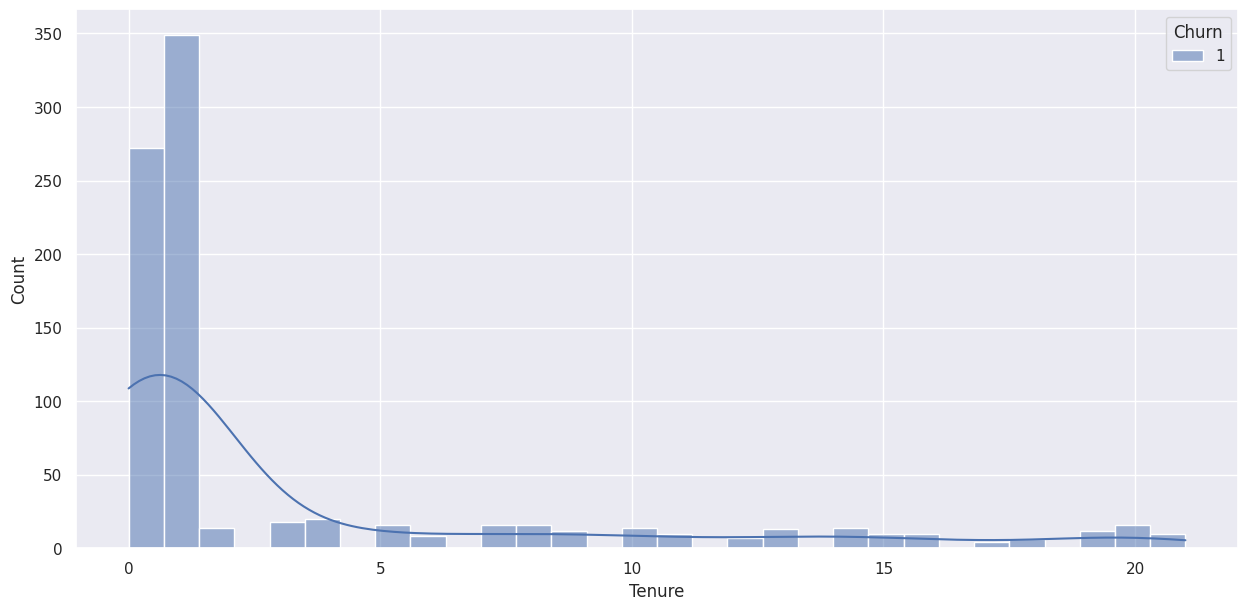

In [59]:
def show_counts(data):
    tenure = data[['Tenure']]
    plt.figure(figsize=(15,7))
    for i in tenure:
        sns.histplot(data=data,x=i,hue='Churn',kde=True,bins=30)
        plt.show()

data0 = data[data['Churn']==0]
show_counts(data0)
data1 = data[data['Churn']==1]
show_counts(data1)

**4. Distributions**

In [60]:
data0[corr_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Churn,4682.0,0.000000,0.000000,0.0,0.00,0.000,0.00,0.00
Tenure,4499.0,11.502334,8.419217,0.0,5.00,10.000,17.00,61.00
CityTier,4682.0,1.619821,0.902332,1.0,1.00,1.000,3.00,3.00
WarehouseToHome,4515.0,15.353931,8.483276,5.0,9.00,13.000,19.00,127.00
NumberOfDeviceRegistered,4682.0,3.639257,1.018910,1.0,3.00,4.000,4.00,6.00
SatisfactionScore,4682.0,3.001282,1.378722,1.0,2.00,3.000,4.00,5.00
Complain,4682.0,0.234088,0.423473,0.0,0.00,0.000,0.00,1.00
DaySinceLastOrder,4429.0,4.807406,3.644758,0.0,2.00,4.000,8.00,31.00
CashbackAmount,4682.0,180.635203,50.434791,0.0,147.24,166.115,201.25,324.99


In [61]:
data1[corr_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Churn,948.0,1.000000,0.000000,1.00,1.00,1.00,1.00,1.00
Tenure,867.0,3.379469,5.486089,0.00,0.00,1.00,3.00,21.00
CityTier,948.0,1.827004,0.959380,1.00,1.00,1.00,3.00,3.00
WarehouseToHome,864.0,17.134259,8.631132,5.00,9.00,15.00,24.00,36.00
NumberOfDeviceRegistered,948.0,3.934599,1.014127,1.00,3.00,4.00,5.00,6.00
SatisfactionScore,948.0,3.390295,1.342031,1.00,3.00,3.00,5.00,5.00
Complain,948.0,0.535865,0.498975,0.00,0.00,1.00,1.00,1.00
DaySinceLastOrder,894.0,3.236018,3.415137,0.00,1.00,2.00,5.00,46.00
CashbackAmount,948.0,160.370928,38.436055,110.09,132.02,149.66,174.69,323.59


Numerical columns that are actually categorical

In [62]:
num_but_cat = [col for col in data.columns if data[col].nunique() < 10 and data[col].dtypes != "O"]
print(num_but_cat)


['Churn', 'CityTier', 'HourSpendOnApp', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'Complain']


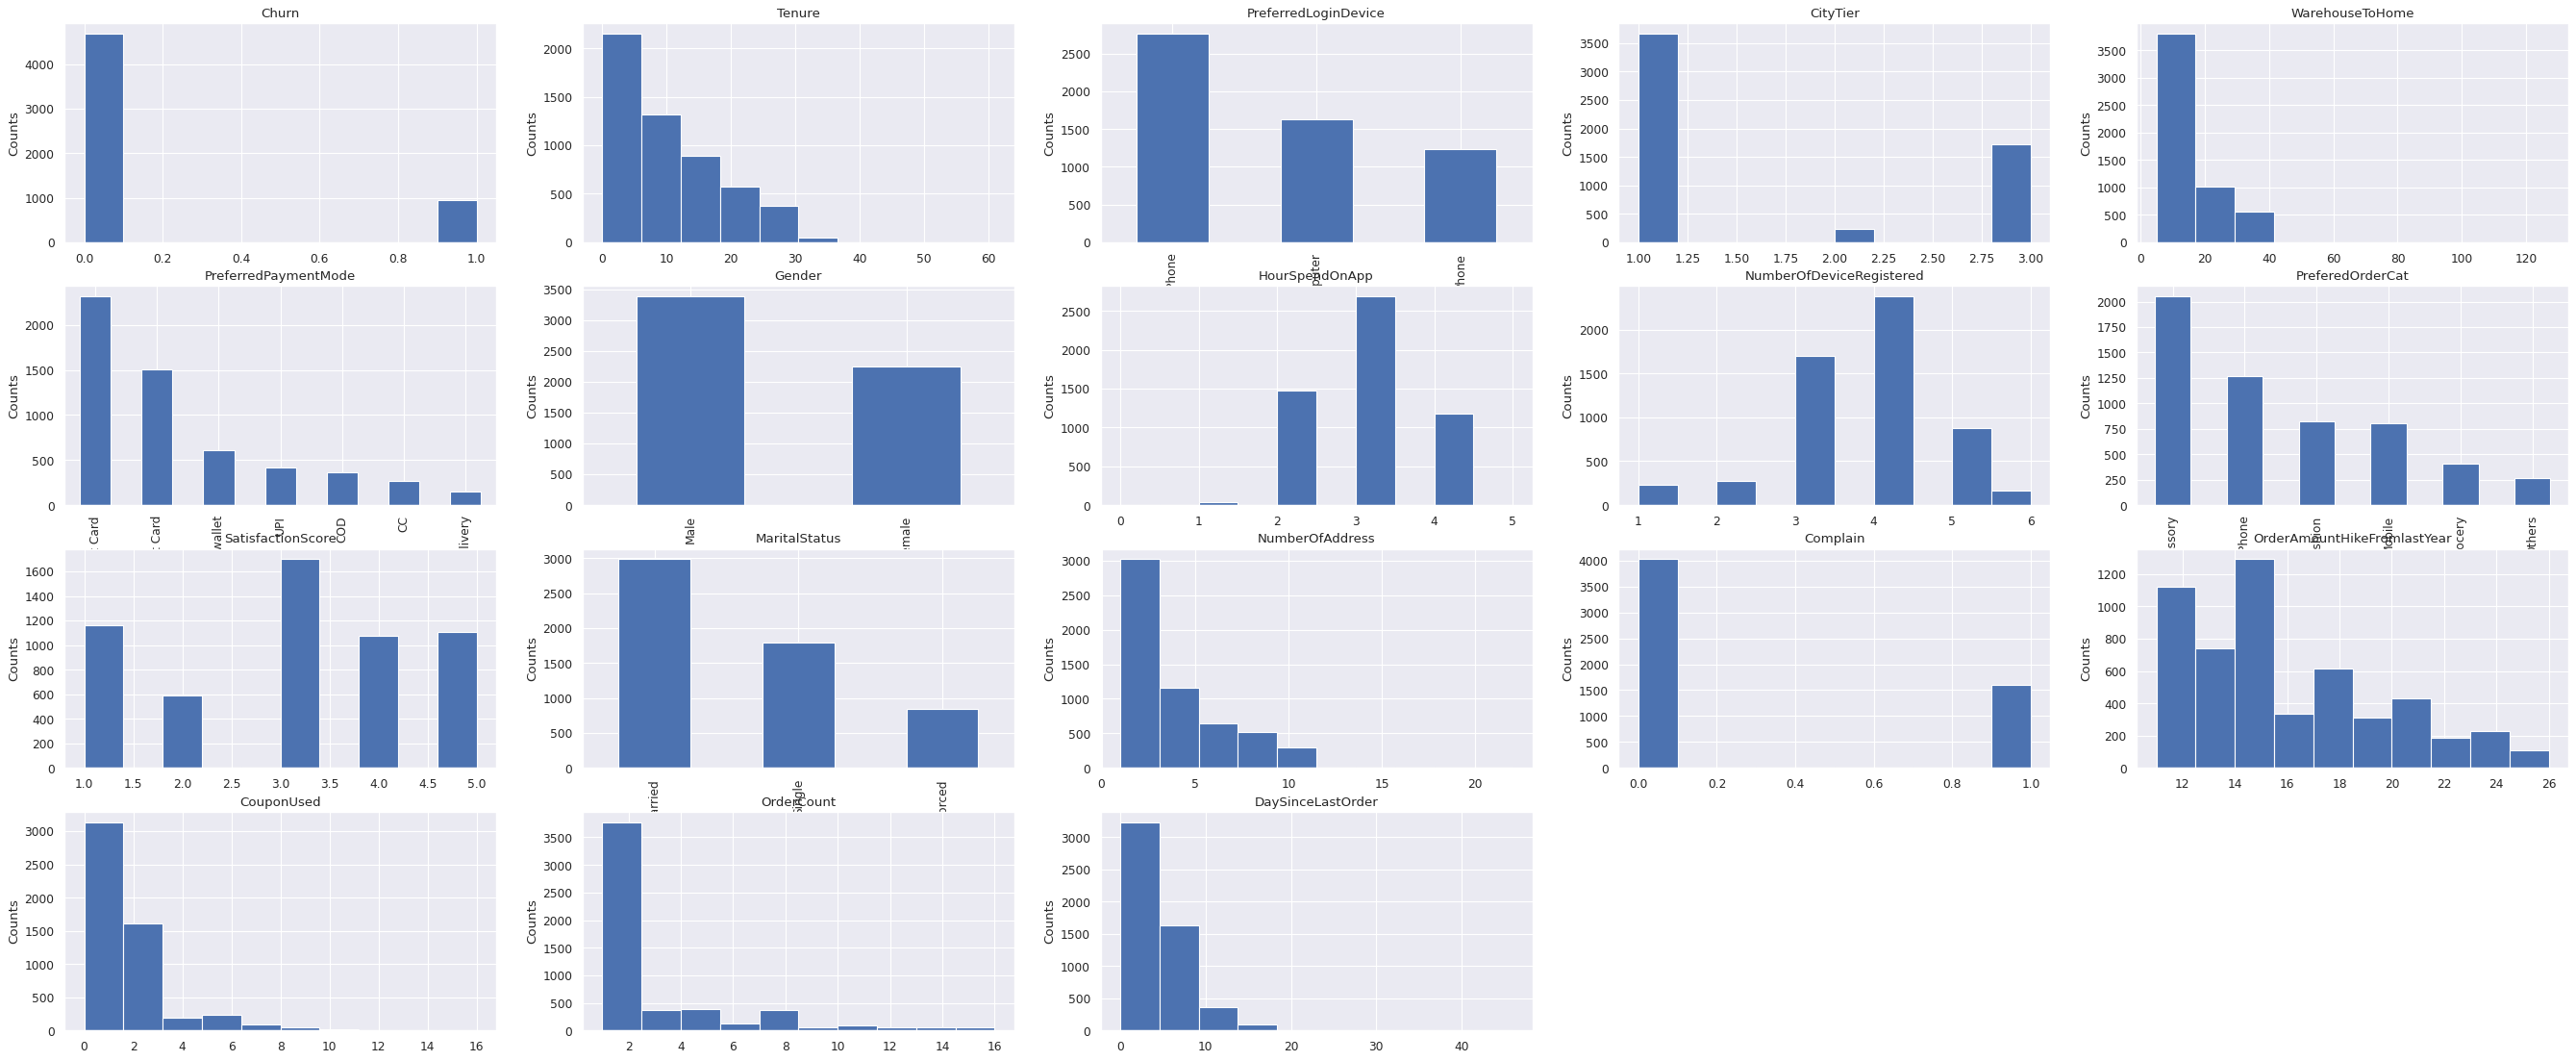

In [63]:
barplotsColumns(data, nLower = 1, nUpper = 1000)

**5.Missing values**

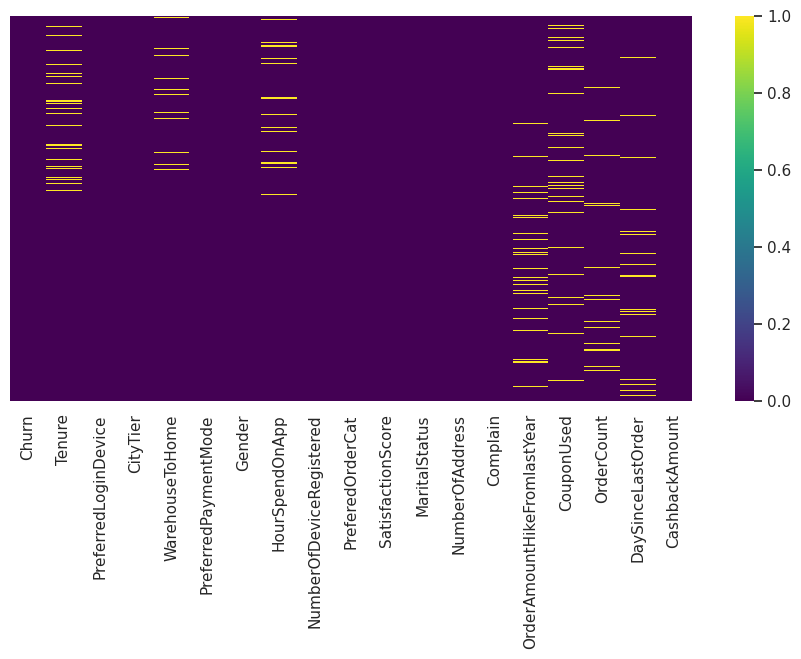

In [64]:
sns.heatmap(data.isnull(),yticklabels=False,cmap="viridis")
plt.show()

In [65]:
def missing_values_table(data, na_name=False):
    na_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (data[na_columns].isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

na_columns = missing_values_table(data, na_name=True)

                             n_miss  ratio
DaySinceLastOrder               307   5.45
OrderAmountHikeFromlastYear     265   4.71
Tenure                          264   4.69
OrderCount                      258   4.58
CouponUsed                      256   4.55
HourSpendOnApp                  255   4.53
WarehouseToHome                 251   4.46


In [66]:
data["DaySinceLastOrder"].fillna(data["DaySinceLastOrder"].median(), inplace=True)
data["OrderAmountHikeFromlastYear"].fillna(data["OrderAmountHikeFromlastYear"].median(), inplace=True)
data["Tenure"].fillna(data["Tenure"].median(), inplace=True)
data["OrderCount"].fillna(data["OrderCount"].median(), inplace=True)
data["CouponUsed"].fillna(data["CouponUsed"].median(), inplace=True)
data["HourSpendOnApp"].fillna(data["HourSpendOnApp"].median(), inplace=True)
data["WarehouseToHome"].fillna(data["WarehouseToHome"].median(), inplace=True)

Check

In [67]:
na_columns = missing_values_table(data, na_name=True)

Empty DataFrame
Columns: [n_miss, ratio]
Index: []
